#### So, let's start our code by importing libraries required

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm

#### Let's import the Dataset

In [33]:
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [34]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [35]:
df.shape, test.shape

((7613, 5), (3263, 4))

#### Plotting the number of  disaster and non disaster tweets

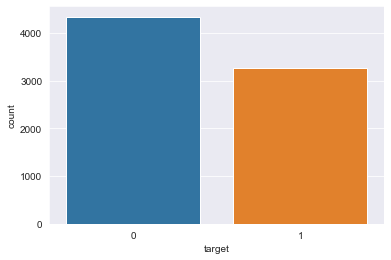

In [36]:
sns.countplot(df["target"]);

In [37]:
df["target"].value_counts(normalize = True) #normalized value counts

0    0.57034
1    0.42966
Name: target, dtype: float64

#### Creating a function for plotting a histogram (for length of tweets)

In [38]:
def len_plot(data, name):
  length = [len(sent.split()) for sent in data]
  plt.hist(length)
  plt.title(name)

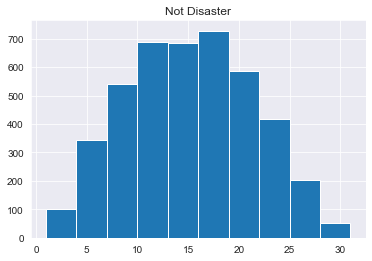

In [39]:
len_plot(df[df["target"]==0]["text"], "Not Disaster") #passing non disaster tweets

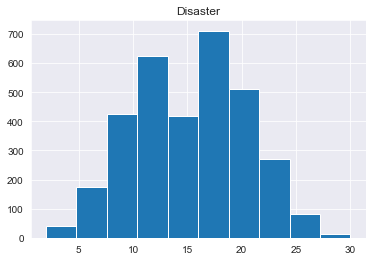

In [40]:
len_plot(df[df["target"]==1]["text"], "Disaster") #passing disaster tweets

#### Separating input and output features

In [41]:
X = df["text"] # indpendent
y = df["target"] # dependent
y = np.array(y) # converting into array

#### Function for finding the number of unique words in our dataset

In [42]:
def unique_words(text):
  unique_words_list = []
  for sent in tqdm(text):
    for word in sent.split():
      if word.lower() not in unique_words_list:
        unique_words_list.append(word.lower())
      else:
        pass
  return unique_words_list
un_words = unique_words(X)

100%|█████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:09<00:00, 779.94it/s]


In [43]:
print("Total number of unique words :",len(un_words))

Total number of unique words : 27983


In [44]:
un_words[:50]

['our',
 'deeds',
 'are',
 'the',
 'reason',
 'of',
 'this',
 '#earthquake',
 'may',
 'allah',
 'forgive',
 'us',
 'all',
 'forest',
 'fire',
 'near',
 'la',
 'ronge',
 'sask.',
 'canada',
 'residents',
 'asked',
 'to',
 "'shelter",
 'in',
 "place'",
 'being',
 'notified',
 'by',
 'officers.',
 'no',
 'other',
 'evacuation',
 'or',
 'shelter',
 'place',
 'orders',
 'expected',
 '13,000',
 'people',
 'receive',
 '#wildfires',
 'california',
 'just',
 'got',
 'sent',
 'photo',
 'from',
 'ruby',
 '#alaska']

#### As it is a twitter dataset, it contains several words starting with "@" and "#". Let's find this words

#### words with starting letter "#"

In [45]:
SYMBOL1 = "#"
words_sym1 = [word for word in un_words if word.startswith(SYMBOL1)]
len(words_sym1)

1965

In [46]:
words_sym1[:50]

['#earthquake',
 '#wildfires',
 '#alaska',
 '#rockyfire',
 '#cafire',
 '#flood',
 '#disaster',
 '#flooding',
 '#raining',
 '#florida',
 '#tampabay',
 '#tampa',
 '#we',
 '#breaking',
 '#metal',
 '#rt',
 '#africanbaze:',
 '#mufc',
 '#bridgetown',
 '#nsfw',
 '#kurds',
 '#diyala',
 '#california',
 '#climate',
 '#energy',
 '#nowplaying:',
 '#edm',
 '#nashvilletraffic.',
 '#santaclara',
 '#bayarea',
 '#traffic',
 '#personalinjury',
 '#solicitor',
 '#otleyhour',
 '#stlouis',
 '#caraccidentlawyer',
 '#truckcrash',
 '#fortworth',
 '#ashville',
 '#manchester',
 '#breaking:',
 '#hagerstown',
 '#whag',
 '#bahrain',
 '#dubstep',
 '#trapmusic',
 '#dnb',
 '#dance',
 '#ices\x89û_',
 '#growingupspoiled']

#### words with starting letter "@"

In [47]:
# words with starting letter "@"
SYMBOL2 = "@"
words_sym2 = [word for word in un_words if word.startswith(SYMBOL2)]
len(words_sym2)

2264

In [48]:
words_sym2[:50]

['@bbcmtd',
 '@phdsquares',
 '@southridgelife',
 '@\x89û_',
 '@navista7',
 '@news24680',
 '@nxwestmidlands',
 '@ablaze',
 '@sleepjunkies:',
 '@your4state.',
 '@flowri',
 '@aftershock_delo',
 '@djicemoon',
 '@kjfordays',
 '@esquireattire',
 '@onfireanders',
 '@cod8sandscrims',
 '@empirikgaming',
 '@codawscrims',
 '@4tp_kotc',
 '@4tpfa',
 '@aftershock_org',
 '@crobscarla',
 '@alexalltimelow',
 '@youtube',
 '@mickinyman',
 '@theatlantic',
 '@20skyhawkmm20',
 '@traplord_29',
 '@fredosantana300',
 '@lilreese300',
 '@tanslash',
 '@fouseytube',
 '@thenissonian',
 '@rejectdcartoons',
 '@kiwi_karyn',
 '@medic914',
 '@aace_org',
 '@marksmaponyane',
 '@volfan326',
 '@tneazzy',
 '@acarewornheart',
 '@viralspell',
 '@amirkingkhan',
 '@floydmayweather',
 '@violentfeminazi',
 '@philipduncan',
 '@breakfastone',
 '@stormbeard',
 '@steel_lord']

Since many of the words starting with "@" doesn't give any impact to our model accuracy, so we need to remove it

#### Function for url removing

In [49]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

#### Lemmatizer

In [50]:
from nltk.stem import WordNetLemmatizer
wl = WordNetLemmatizer()

#### Preprocessing function

In [51]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shari\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shari\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [52]:
def preprocessing(text):
  
  tweets = []
  for tweet in tqdm(text):
    tweet = tweet.lower() # converting to lower case
    tweet =  remove_urls(tweet) # url removing
    tweet = re.sub(r'@\w+',  '', tweet).strip() # removing the words start with "@"
    tweet = re.sub("[^a-zA-Z0-9 ']", "", tweet) # removing unwanted symbols
    tweet = tweet.split()
    tweet1 = [wl.lemmatize(word) for word in tweet if word not in set(stopwords.words("english"))] #lemmatization and stopwrds removal
    tweet1 = " ".join(tweet1)
    tweets.append(tweet1)
  return tweets

tweets = preprocessing(X)

100%|█████████████████████████████████████████████████████████████████████████████| 7613/7613 [00:30<00:00, 253.26it/s]


In [53]:
tweets[:50]

['deed reason earthquake may allah forgive u',
 'forest fire near la ronge sask canada',
 "resident asked 'shelter place' notified officer evacuation shelter place order expected",
 '13000 people receive wildfire evacuation order california',
 'got sent photo ruby alaska smoke wildfire pours school',
 'rockyfire update california hwy 20 closed direction due lake county fire cafire wildfire',
 'flood disaster heavy rain cause flash flooding street manitou colorado spring area',
 "i'm top hill see fire wood",
 "there's emergency evacuation happening building across street",
 "i'm afraid tornado coming area",
 'three people died heat wave far',
 'haha south tampa getting flooded hah wait second live south tampa gonna gonna fvck flooding',
 "raining flooding florida tampabay tampa 18 19 day i've lost count",
 'flood bago myanmar arrived bago',
 'damage school bus 80 multi car crash breaking',
 "what's man",
 'love fruit',
 'summer lovely',
 'car fast',
 'goooooooaaaaaal',
 'ridiculous',
 '

### LSTM

In [54]:
# importing libraries
import tensorflow as tf
tf.__version__

from tensorflow.keras.layers import (Embedding,
                                     LSTM,
                                     Dense,
                                     Dropout,
                                     GlobalMaxPool1D,
                                     BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

#### Performing onehot encoding

In [55]:
VOC_SIZE = 30000
onehot_repr = [one_hot(words, VOC_SIZE) for words in tweets]
onehot_repr[100:110]

[[21778, 4678, 23921, 18606, 14013, 12539, 21775, 16985],
 [28514,
  20124,
  4345,
  27407,
  26279,
  12944,
  3008,
  14601,
  12539,
  2606,
  17164,
  16656],
 [24909, 23871, 24400, 1245, 1080],
 [6048, 24135, 26590, 5250, 9882, 698, 24135, 16552, 25352, 8570],
 [21496, 448, 16743, 10983, 27855, 7871, 17527, 636, 29555, 323],
 [6590, 16854, 14615, 28760, 24789, 8897, 23307, 19660],
 [21496, 448, 16743, 10983, 27855, 7871, 17527, 636, 29555, 323],
 [22549, 29405, 18428, 860, 13014, 28132],
 [3450, 6680, 27442, 3527, 24909, 6941, 19546, 8994, 1901, 23871, 7367],
 [6048, 14430, 16429, 23727, 27195, 19297, 22744]]

In [56]:
# finding sentence length for each tweets
word_length = []
for i in onehot_repr:
  word_length.append(len(i))

len(word_length)

7613

In [57]:
word_length[1100:1150]

[3,
 12,
 17,
 14,
 17,
 2,
 11,
 12,
 10,
 2,
 4,
 10,
 11,
 5,
 12,
 13,
 8,
 8,
 5,
 9,
 8,
 6,
 10,
 7,
 15,
 5,
 7,
 10,
 17,
 4,
 3,
 8,
 11,
 7,
 13,
 11,
 11,
 11,
 8,
 14,
 10,
 5,
 7,
 6,
 7,
 7,
 7,
 7,
 7,
 9]

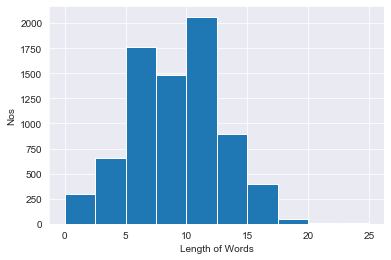

In [58]:
# plotting graph (length of the tweets vs Numbers)
plt.hist(word_length)
plt.xlabel("Length of Words")
plt.ylabel("Nos")
plt.show()

In [60]:
max(word_length) # lenth of the longest tweet

25

#### Padding the Sequence

In [61]:
SENT_LENGTH = 15
embedded_docs = pad_sequences(onehot_repr, padding="post", maxlen=SENT_LENGTH)
embedded_docs

array([[ 2634,  9991,  4779, ...,     0,     0,     0],
       [18864, 29910, 21628, ...,     0,     0,     0],
       [18724,   415,  2455, ...,     0,     0,     0],
       ...,
       [23600,  5075, 16264, ...,     0,     0,     0],
       [ 4678, 10529,  4243, ...,  8291, 29804,     0],
       [11670, 27943, 17867, ...,     0,     0,     0]])

#### Function for model creation

In [62]:
def create_model():
  VECT_FEATURES = 32
  model = Sequential()
  model.add(Embedding(VOC_SIZE,
                      VECT_FEATURES,
                      input_length=SENT_LENGTH))
  model.add(LSTM(100, return_sequences = True))
  model.add(GlobalMaxPool1D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(10, activation="relu"))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation = "sigmoid"))
  return model


In [63]:
model = create_model()
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"]) # compiling
model.summary() #summary

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 32)            960000    
_________________________________________________________________
lstm (LSTM)                  (None, 15, 100)           53200     
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
________________________________________________________

#### Training the Model

In [64]:
history = model.fit(embedded_docs, y, epochs=6, batch_size=32)

Epoch 1/6
7613/7613 [==============================] - 7s 859us/sample - loss: 0.5562 - acc: 0.7140
Epoch 2/6
7613/7613 [==============================] - 6s 770us/sample - loss: 0.3619 - acc: 0.8563
Epoch 3/6
7613/7613 [==============================] - 6s 740us/sample - loss: 0.2537 - acc: 0.9040
Epoch 4/6
7613/7613 [==============================] - 6s 758us/sample - loss: 0.1850 - acc: 0.9321
Epoch 5/6
7613/7613 [==============================] - 6s 792us/sample - loss: 0.1397 - acc: 0.9492
Epoch 6/6
7613/7613 [==============================] - 6s 770us/sample - loss: 0.1277 - acc: 0.9522


#### Plotting the graph of model accuracy and loss

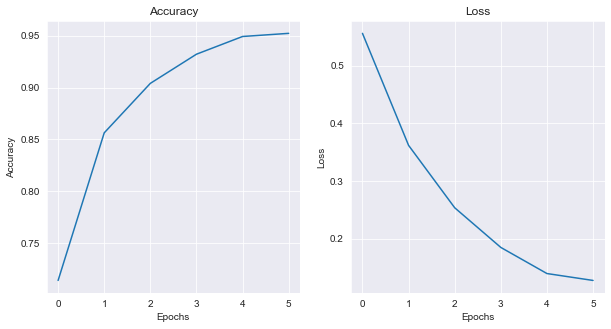

In [67]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.plot(history.history["acc"])
ax1.set_title("Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")

ax2.plot(history.history["loss"])
ax2.set_title("Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
plt.show()